In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

drive_dirpath = "/content/drive/Othercomputers/My MacBook Pro/LLM workshop/final-project/part2/"

Mounted at /content/drive


In [4]:
combined_df = pd.read_excel(os.path.join(drive_dirpath, "combined_dataframes.xlsx"))

## Final Dataset Statistics

In [6]:
# Count the number of times combined_df.dataset == 'tested'
tested_count = combined_df[combined_df.dataset == 'tested'].shape[0]
print(f"Number of rows where dataset is 'tested': {tested_count}")

untested_count = combined_df[combined_df.dataset == 'untested'].shape[0]
print(f"Number of rows where dataset is 'untested': {untested_count}\n")

# Count how many times each of A, B, C, D appears in combined_df.question_type
for question_type in ['A', 'B', 'C', 'D']:
  count = combined_df[combined_df.question_type == question_type].shape[0]
  print(f"Number of rows with question type {question_type}: {count}")

Number of rows where dataset is 'tested': 277
Number of rows where dataset is 'untested': 144

Number of rows with question type A: 220
Number of rows with question type B: 37
Number of rows with question type C: 212
Number of rows with question type D: 91


In [7]:
# prompt: For each value in 'a','b','c',...,'p'  - count how many rows in combined_df.topics_covered contain the char, except if the cell value == 'na'

import string

alphabet = string.ascii_lowercase[:16]  # 'a' to 'p'

for char in alphabet:
  count = combined_df[
      combined_df.topics_covered.str.contains(char, na=False) &
      (combined_df.topics_covered != 'na')
  ].shape[0]
  print(f"Topic {char}  :   {count}")

Topic a  :   183
Topic b  :   38
Topic c  :   12
Topic d  :   58
Topic e  :   67
Topic f  :   90
Topic g  :   75
Topic h  :   69
Topic i  :   61
Topic j  :   19
Topic k  :   70
Topic l  :   13
Topic m  :   58
Topic n  :   26
Topic o  :   9
Topic p  :   66


In [8]:
# remove questions without solutions (solution == FALSE)
# remove questions of type a and b
# remove questionsn that are not "tested"
# change question_type to upper case
# change multiple_choice_answer column to numbers
# keep columns: exam_year, semester, moed, question_number, multiple_choice_answer

combined_df['question_type'] = combined_df['question_type'].str.upper()
df_cd = combined_df[(combined_df['question_type'] == "C") | (combined_df['question_type'] == "D")]
df_cd = df_cd[(df_cd['dataset']=='tested')]
df_cd = df_cd[df_cd['has_solution'] == True].reset_index()
df_cd_small = df_cd[['exam_year','semester','moed','question_number','multiple_choice_answer','number_of_possible_answers','topics_covered','points']]
df_b = combined_df[(combined_df['question_type'] == "B")]
df_b = df_b[(df_b['dataset']=='tested')]
df_b = df_b[df_b['has_solution'] == True].reset_index()
df_b_small = df_b[['exam_year','semester','moed','question_number','answer_translation_latex','topics_covered','points']]

## Histogram of Number of Possible Answers and Boxlot of random guess probabilites

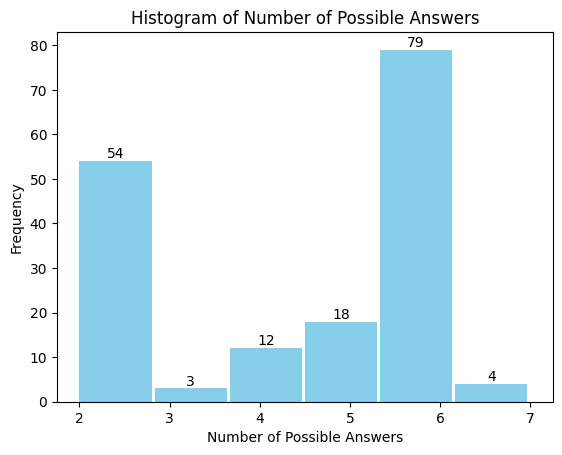

In [9]:
counts, bins, patches = plt.hist(df_cd['number_of_possible_answers'], bins=6, color='skyblue', width=0.8)

# Add count labels above each bar
for count, patch in zip(counts, patches):
    plt.text(
        patch.get_x() + patch.get_width()/2,  # x position (center of bar)
        count,  # y position
        f'{int(count)}',  # label (convert to integer)
        ha='center',  # horizontal alignment
        va='bottom'   # vertical alignment
    )

plt.xlabel('Number of Possible Answers')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Possible Answers')
plt.show()

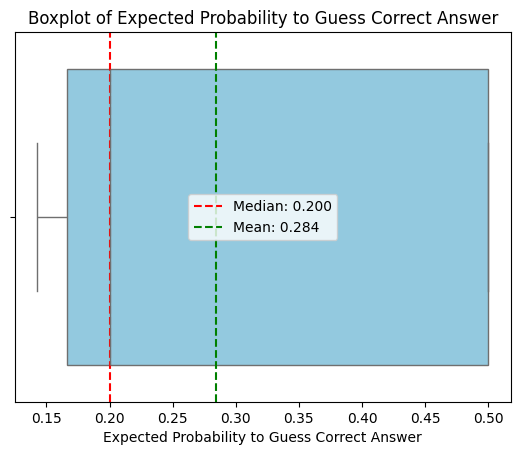

In [10]:
df_cd['expected_prob_to_guess_correct_answer'] = 1 / df_cd['number_of_possible_answers']
plt.figure()
sns.boxplot(x=df_cd['expected_prob_to_guess_correct_answer'], color='skyblue')
plt.xlabel('Expected Probability to Guess Correct Answer')
plt.title('Boxplot of Expected Probability to Guess Correct Answer')

# Calculate and display the median
median_value = df_cd['expected_prob_to_guess_correct_answer'].median()
plt.axvline(median_value, color='red', linestyle='--', label=f'Median: {median_value:.3f}')

# Calculate and display the mean
mean_value = df_cd['expected_prob_to_guess_correct_answer'].mean()
plt.axvline(mean_value, color='green', linestyle='--', label=f'Mean: {mean_value:.3f}')

plt.legend()
plt.show()

In [11]:
# Create a mapping for letters and True/False values
mapping = {
    1:1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7:7,
    'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G':7,
    'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g':7,
    'True': 1, 'False': 0, True: 1, False: 0
}

df_cd_small.loc[:, 'multiple_choice_answer'] = df_cd_small['multiple_choice_answer'].map(mapping)

In [12]:
df_cd_small.loc[:,'semester'] = df_cd_small['semester'].str.upper()
df_cd_small.loc[:,'moed'] = df_cd_small['moed'].str.upper()

df_b_small.loc[:,'semester'] = df_cd_small['semester'].str.upper()
df_b_small.loc[:,'moed'] = df_cd_small['moed'].str.upper()

In [13]:
model_df = pd.read_excel(os.path.join(drive_dirpath, "cd-results.xlsx"))
model_df_b = pd.read_excel(os.path.join(drive_dirpath, "b-results.xlsx"))

In [14]:
df_cd_expanded = df_cd_small.loc[df_cd_small.index.repeat(10)].reset_index(drop=True)
df_cd_expanded['fixed_model_reponses'] = model_df['fixed_chat_response']
df_cd_expanded['prompt_engineering_method'] = model_df['prompt_engineering_method']
df_cd_expanded['prompt_engineering_method'].fillna('-', inplace = True)

df_b_expanded = df_b_small.loc[df_b_small.index.repeat(10)].reset_index(drop=True)
df_b_expanded['model_reponses'] = model_df_b['chat_response']
df_b_expanded['prompt_engineering_method'] = model_df_b['prompt_engineering_method']
df_b_expanded['eval_by_hand'] = model_df_b['is_correct_eval_by_hand']
df_b_expanded['prompt_engineering_method'].fillna('-', inplace = True)

<ipython-input-14-8255ab014ebf>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cd_expanded['prompt_engineering_method'].fillna('-', inplace = True)
<ipython-input-14-8255ab014ebf>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [15]:
df_cd_expanded

,exam_year,semester,moed,question_number,multiple_choice_answer,number_of_possible_answers,topics_covered,points,fixed_model_reponses,prompt_engineering_method
0,2002,A,A,2,2,5,p,6,5,-
1,2002,A,A,2,2,5,p,6,5,-
2,2002,A,A,2,2,5,p,6,5,-
3,2002,A,A,2,2,5,p,6,2,-
4,2002,A,A,2,2,5,p,6,4,-
...,...,...,...,...,...,...,...,...,...,...
1695,2018,A,A,14-e,0,2,"b,h",4,0,COT
1696,2018,A,A,14-e,0,2,"b,h",4,0,COT
1697,2018,A,A,14-e,0,2,"b,h",4,0,COT
1698,2018,A,A,14-e,0,2,"b,h",4,0,COT


In [16]:
df_b_expanded_eval = df_b_expanded.dropna()
df_b_expanded_eval.rename(columns={'eval_by_hand':'tight_accuracy'}, inplace=True)
df_b_expanded_eval


<ipython-input-16-1179011fa813>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_expanded_eval.rename(columns={'eval_by_hand':'tight_accuracy'}, inplace=True)


,exam_year,semester,moed,question_number,answer_translation_latex,topics_covered,points,model_reponses,prompt_engineering_method,tight_accuracy
10,2010,A,A,2-d,\begin{quote}\nThe first two lines require tim...,"m,c,j",na,The running time of the algorithm is \( O(n t ...,-,0.0
11,2010,A,A,2-d,\begin{quote}\nThe first two lines require tim...,"m,c,j",na,The running time of the algorithm is \(O(t \cd...,-,0.0
12,2010,A,A,2-d,\begin{quote}\nThe first two lines require tim...,"m,c,j",na,The running time of the algorithm is \( O(m) \).,-,0.0
13,2010,A,A,2-d,\begin{quote}\nThe first two lines require tim...,"m,c,j",na,"The running time of the algorithm is \(O(m)\),...",-,0.0
14,2010,A,A,2-d,\begin{quote}\nThe first two lines require tim...,"m,c,j",na,\(O(m \log n)\),-,0.0
...,...,...,...,...,...,...,...,...,...,...
165,2017,B,"A,B",1-a,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n",a,na,"\(n, \, n \log n, \, n \log k, \, n + k \log k...",COT,0.0
166,2017,B,"A,B",1-a,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n",a,na,"\( n, \, n \log n, \, n \log k, \, n + k \log ...",COT,0.0
167,2017,B,"A,B",1-a,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n",a,na,"\( n, n \log n, n \log k, n + k \log k, n^2 \)",COT,0.0
168,2017,B,"A,B",1-a,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n",a,na,"\[ n, \ n \log n, \ n \log k, \ n + k \log k, ...",COT,0.0


In [17]:
df_cd_expanded['diff'] = df_cd_expanded['multiple_choice_answer'] - df_cd_expanded['fixed_model_reponses']
df_cd_expanded['tight_accuracy'] = (df_cd_expanded['diff'] == 0).astype(int)
df_cd_expanded = df_cd_expanded.drop(columns=['diff'])
df_cd_expanded

,exam_year,semester,moed,question_number,multiple_choice_answer,number_of_possible_answers,topics_covered,points,fixed_model_reponses,prompt_engineering_method,tight_accuracy
0,2002,A,A,2,2,5,p,6,5,-,0
1,2002,A,A,2,2,5,p,6,5,-,0
2,2002,A,A,2,2,5,p,6,5,-,0
3,2002,A,A,2,2,5,p,6,2,-,1
4,2002,A,A,2,2,5,p,6,4,-,0
...,...,...,...,...,...,...,...,...,...,...,...
1695,2018,A,A,14-e,0,2,"b,h",4,0,COT,1
1696,2018,A,A,14-e,0,2,"b,h",4,0,COT,1
1697,2018,A,A,14-e,0,2,"b,h",4,0,COT,1
1698,2018,A,A,14-e,0,2,"b,h",4,0,COT,1


In [25]:
df_cd_expanded['question_type'] = 'C,D'
df_b_expanded_eval['question_type'] = 'B'
bcd_expanded_df = pd.concat([df_cd_expanded, df_b_expanded_eval])
bcd_expanded_df

<ipython-input-25-b862a109a6df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_expanded_eval['question_type'] = 'B'


,exam_year,semester,moed,question_number,multiple_choice_answer,number_of_possible_answers,topics_covered,points,fixed_model_reponses,prompt_engineering_method,tight_accuracy,question_type,answer_translation_latex,model_reponses
0,2002,A,A,2,2,5,p,6,5.0,-,0.0,"C,D",NaN,NaN
1,2002,A,A,2,2,5,p,6,5.0,-,0.0,"C,D",NaN,NaN
2,2002,A,A,2,2,5,p,6,5.0,-,0.0,"C,D",NaN,NaN
3,2002,A,A,2,2,5,p,6,2.0,-,1.0,"C,D",NaN,NaN
4,2002,A,A,2,2,5,p,6,4.0,-,0.0,"C,D",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2017,B,"A,B",1-a,NaN,NaN,a,na,NaN,COT,0.0,B,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n","\(n, \, n \log n, \, n \log k, \, n + k \log k..."
166,2017,B,"A,B",1-a,NaN,NaN,a,na,NaN,COT,0.0,B,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n","\( n, \, n \log n, \, n \log k, \, n + k \log ..."
167,2017,B,"A,B",1-a,NaN,NaN,a,na,NaN,COT,0.0,B,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n","\( n, n \log n, n \log k, n + k \log k, n^2 \)"
168,2017,B,"A,B",1-a,NaN,NaN,a,na,NaN,COT,0.0,B,"n^2, n\log{n}, n\log{k}, n+k\log{k}, n","\[ n, \ n \log n, \ n \log k, \ n + k \log k, ..."


In [30]:
bcd_expanded_grouped = bcd_expanded_df.groupby(['exam_year','semester','moed','question_number', 'prompt_engineering_method','topics_covered', 'question_type'])['tight_accuracy'].sum()
bcd_expanded_grouped_df = bcd_expanded_grouped.reset_index()
bcd_expanded_grouped_df['model_was_right_q'] = bcd_expanded_grouped_df['tight_accuracy'] > 2
bcd_expanded_grouped_df

,exam_year,semester,moed,question_number,prompt_engineering_method,topics_covered,question_type,tight_accuracy,model_was_right_q
0,2002,A,A,2,-,p,"C,D",1.0,False
1,2002,A,A,2,COT,p,"C,D",1.0,False
2,2002,A,A,3,-,g,"C,D",5.0,True
3,2002,A,A,3,COT,g,"C,D",5.0,True
4,2002,A,A,4,-,g,"C,D",5.0,True
...,...,...,...,...,...,...,...,...,...
365,2018,A,B,6-a,COT,j,"C,D",5.0,True
366,2018,A,B,8-a,-,g,"C,D",4.0,True
367,2018,A,B,8-a,COT,g,"C,D",4.0,True
368,2018,A,B,8-c,-,g,"C,D",2.0,False


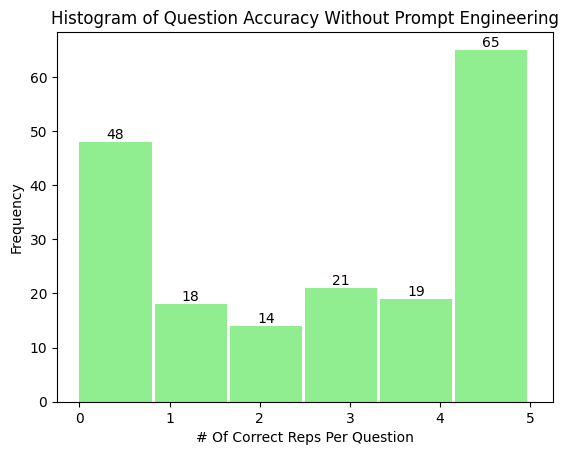

In [27]:
plt.figure()
n, bins, patches = plt.hist(bcd_expanded_grouped_df[bcd_expanded_grouped_df['prompt_engineering_method'] == '-'].tight_accuracy, bins=6, color='lightgreen', width=0.8)
plt.xlabel('# Of Correct Reps Per Question')
plt.ylabel('Frequency')
plt.title('Histogram of Question Accuracy Without Prompt Engineering')

# Annotate each bar with the count
for count, patch in zip(n, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
             ha='center', va='bottom')

plt.show()

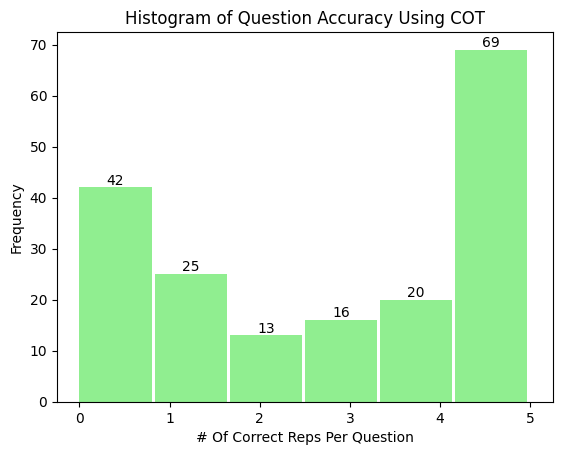

In [28]:
plt.figure()
n, bins, patches = plt.hist(bcd_expanded_grouped_df[bcd_expanded_grouped_df['prompt_engineering_method'] == 'COT'].tight_accuracy, bins=6, color='lightgreen', width=0.8)
plt.xlabel('# Of Correct Reps Per Question')
plt.ylabel('Frequency')
plt.title('Histogram of Question Accuracy Using COT')

# Annotate each bar with the count
for count, patch in zip(n, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
             ha='center', va='bottom')

plt.show()

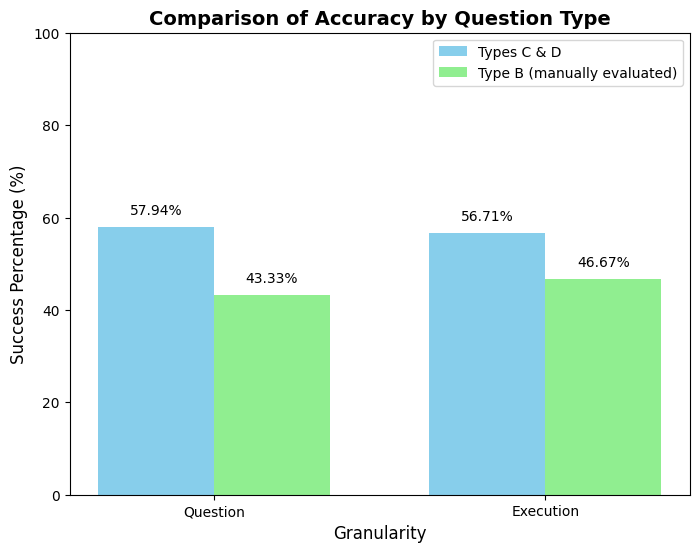

In [54]:
# Data setup
categories = ["Question", "Execution"]

total_cd_executions = len(bcd_expanded_df[bcd_expanded_df['question_type'] != 'B'])
total_b_executions = len(bcd_expanded_df[bcd_expanded_df['question_type'] == 'B'])

cd_percentage_per_question = bcd_expanded_grouped_df[bcd_expanded_grouped_df['question_type'] != 'B']['model_was_right_q'].mean() * 100
b_percentage_per_question = bcd_expanded_grouped_df[bcd_expanded_grouped_df['question_type'] == 'B']['model_was_right_q'].mean() * 100
cd_percentage_per_execution = (bcd_expanded_df[bcd_expanded_df['question_type'] != 'B']['tight_accuracy'].sum() / total_cd_executions) * 100
b_percentage_per_execution = (bcd_expanded_df[bcd_expanded_df['question_type'] == 'B']['tight_accuracy'].sum() / total_b_executions) * 100


values_cd = [cd_percentage_per_question, cd_percentage_per_execution]
values_b_by_hand = [b_percentage_per_question, b_percentage_per_execution]

# Calculate the number of categories and bar width
x = np.arange(len(categories))
width = 0.35

# Set a Seaborn style for a different look

# Create the figure and axis
plt.figure(figsize=(8, 6))

# Plot bars with custom colors and bar position adjustments
bars_cd = plt.bar(x - width/2, values_cd, width, label='Types C & D', color='skyblue')
bars_b_by_hand = plt.bar(x + width/2, values_b_by_hand, width, label='Type B (manually evaluated)', color='lightgreen')

# Set labels and title with customized font sizes
plt.xlabel('Granularity', fontsize=12)
plt.ylabel('Success Percentage (%)', fontsize=12)
plt.title('Comparison of Accuracy by Question Type', fontsize=14, fontweight='bold')

# Customize tick labels and limits
plt.xticks(x, categories)
plt.ylim(0, 100)

# Add annotations above bars for visibility
for bar in bars_cd:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f"{yval:.2f}%", ha='center', va='bottom', fontsize=10)

for bar in bars_b_by_hand:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f"{yval:.2f}%", ha='center', va='bottom', fontsize=10)

# Display legend
plt.legend()

# Show the plot
plt.show()

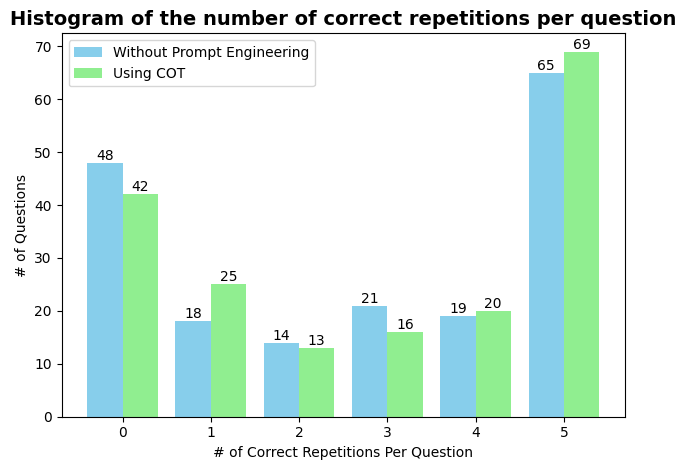

exam_year                    185
semester                     185
moed                         185
question_number              185
prompt_engineering_method    185
topics_covered               185
tight_accuracy               185
model_was_right_q            185
dtype: int64
exam_year                    185
semester                     185
moed                         185
question_number              185
prompt_engineering_method    185
topics_covered               185
tight_accuracy               185
model_was_right_q            185
dtype: int64


In [57]:
# Calculate histogram data for both methods
data_no_cot = bcd_expanded_grouped_df[bcd_expanded_grouped_df['prompt_engineering_method'] == '-'].tight_accuracy
data_cot = bcd_expanded_grouped_df[bcd_expanded_grouped_df['prompt_engineering_method'] == 'COT'].tight_accuracy
n_no_cot, bins_no_cot = np.histogram(data_no_cot, bins=6)
n_cot, bins_cot = np.histogram(data_cot, bins=6)

# Calculate bin centers and tick positions
bin_centers = (bins_no_cot[:-1] + bins_no_cot[1:]) / 2
tick_positions = bin_centers  # Use bin centers as x-axis ticks

# Create the figure
plt.figure()

# Bar width and offsets
bar_width = (bins_no_cot[1] - bins_no_cot[0]) * 0.4  # Adjust width as needed
offset = bar_width / 2

# Plot bars for each method with an offset
plt.bar(bin_centers - offset, n_no_cot, width=bar_width, color='skyblue', label='Without Prompt Engineering')
plt.bar(bin_centers + offset, n_cot, width=bar_width, color='lightgreen', label='Using COT')

# Adding labels above each bar
for x, count in zip(bin_centers - offset, n_no_cot):
    plt.text(x, count, int(count), ha='center', va='bottom')
for x, count in zip(bin_centers + offset, n_cot):
    plt.text(x, count, int(count), ha='center', va='bottom')

# Set labels, title, and tick positions
plt.xlabel('# of Correct Repetitions Per Question')
plt.ylabel('# of Questions')
plt.title('Histogram of the number of correct repetitions per question', fontsize=14, fontweight='bold')
plt.legend()

# Set x-axis ticks to match bin centers
plt.xticks(tick_positions, labels=[f'{i}' for i in range(len(bin_centers))])

# Display the plot
plt.tight_layout()
plt.show()

print(bcd_expanded_grouped_df[bcd_expanded_grouped_df['prompt_engineering_method'] == '-'].count())
print(bcd_expanded_grouped_df[bcd_expanded_grouped_df['prompt_engineering_method'] == 'COT'].count())

In [66]:
# counts of all topics (in each prompt!!!)
all_topic_counts = bcd_expanded_df['topics_covered'].str.split(',').explode().value_counts()
all_topic_counts

,count
topics_covered,
a,660
e,280
h,240
d,220
g,220
p,220
m,210
i,210
k,170


In [67]:
cot_correct = bcd_expanded_df[(bcd_expanded_df['tight_accuracy'] == 1) & (bcd_expanded_df['prompt_engineering_method'] == 'COT')]
cot_correct_topic_cnt = cot_correct['topics_covered'].str.split(',').explode().value_counts()
cot_correct_topic_cnt

,count
topics_covered,
a,214
d,79
e,75
h,72
p,67
g,63
i,61
k,58
m,40


In [68]:
no_cot_correct = bcd_expanded_df[(bcd_expanded_df['tight_accuracy'] == 1) & (bcd_expanded_df['prompt_engineering_method'] == '-')]
no_cot_correct_topic_cnt = no_cot_correct['topics_covered'].str.split(',').explode().value_counts()
no_cot_correct_topic_cnt

,count
topics_covered,
a,209
h,75
e,73
d,72
p,65
g,64
i,57
k,45
m,41


In [69]:
all_by_topic = pd.merge(cot_correct_topic_cnt, no_cot_correct_topic_cnt, on='topics_covered')
all_by_topic.rename(columns={'count_x':'cot','count_y':'no_cot'}, inplace=True)
all_by_topic_2 = pd.merge(all_by_topic, all_topic_counts, on='topics_covered')
all_by_topic_2.rename(columns={'count':'total'}, inplace=True)
all_by_topic_2.loc['i'] += all_by_topic_2.loc['I']
all_by_topic_2.drop('I', inplace=True)
all_by_topic_2['cot/total'] = round(all_by_topic_2['cot']/all_by_topic_2['total'], 2)
all_by_topic_2['no_cot/total'] = round(all_by_topic_2['no_cot']/all_by_topic_2['total'], 2)
all_by_topic_2 = all_by_topic_2.reset_index().rename(columns={"index":"topics_covered"})
all_by_topic_2.sort_values(by=['topics_covered'], inplace=True)
all_by_topic_2

,topics_covered,cot,no_cot,total,cot/total,no_cot/total
0,a,214,209,660,0.32,0.32
10,b,28,27,140,0.20,0.19
15,c,3,2,30,0.10,0.07
1,d,79,72,220,0.36,0.33
2,e,75,73,280,0.27,0.26
9,f,35,35,150,0.23,0.23
5,g,63,64,220,0.29,0.29
3,h,72,75,240,0.30,0.31
6,i,66,62,220,0.30,0.28
11,j,24,18,70,0.34,0.26


## Comparison of Accuracy by Question Type

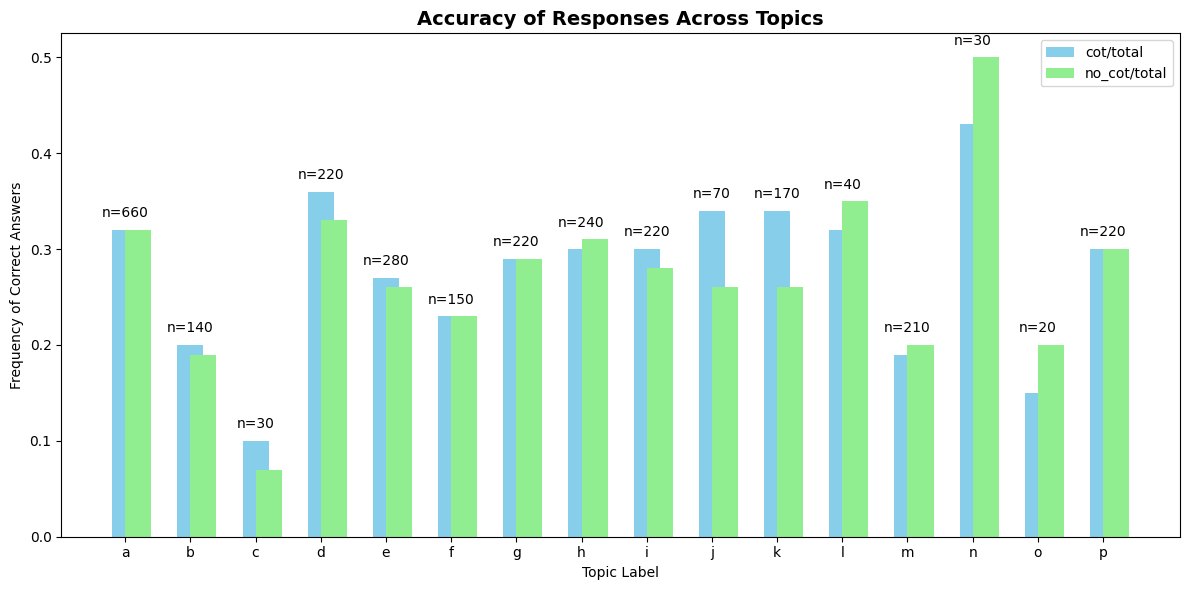

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))
x = all_by_topic_2['topics_covered']


# Creating the bars for 'cot/total' and 'no_cot/total'
ax.bar(x, all_by_topic_2['cot/total'], width=0.4, label='cot/total', align='center', color='skyblue')
ax.bar(x, all_by_topic_2['no_cot/total'], width=0.4, label='no_cot/total', align='edge', color='lightgreen')

# Setting labels and title
ax.set_xlabel('Topic Label')
ax.set_ylabel('Frequency of Correct Answers')
ax.set_title('Accuracy of Responses Across Topics', fontsize=14, fontweight='bold')
ax.legend()

# Adding total count labels
for i, topic in enumerate(x):
    total = all_by_topic_2.loc[all_by_topic_2['topics_covered'] == topic, 'total'].iloc[0]
    # Get the maximum height between the two bars for this topic
    cot_height = all_by_topic_2.loc[all_by_topic_2['topics_covered'] == topic, 'cot/total'].iloc[0]
    no_cot_height = all_by_topic_2.loc[all_by_topic_2['topics_covered'] == topic, 'no_cot/total'].iloc[0]
    max_height = max(cot_height, no_cot_height)

    # Place text slightly above the taller bar
    ax.text(i, max_height + 0.01, f'n={total}',
            ha='center', va='bottom')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [71]:
all_by_topic_2["avg_accuracy"] = (all_by_topic_2["cot/total"] + all_by_topic_2["no_cot/total"])/2

In [72]:
all_by_topic_2.sort_values(by=['avg_accuracy'], inplace=True, ascending=False)
all_by_topic_2

,topics_covered,cot,no_cot,total,cot/total,no_cot/total,avg_accuracy
13,n,13,15,30,0.43,0.50,0.465
1,d,79,72,220,0.36,0.33,0.345
12,l,13,14,40,0.32,0.35,0.335
0,a,214,209,660,0.32,0.32,0.320
3,h,72,75,240,0.30,0.31,0.305
11,j,24,18,70,0.34,0.26,0.300
7,k,58,45,170,0.34,0.26,0.300
4,p,67,65,220,0.30,0.30,0.300
6,i,66,62,220,0.30,0.28,0.290
5,g,63,64,220,0.29,0.29,0.290
